<a href="https://colab.research.google.com/github/yexf308/OTT-Hessian/blob/main/Hessian_accuracy_uniform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Load Package
### Set to double precision

In [ ]:
from jax import config
config.update("jax_enable_x64", True)
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import jax
import jax.numpy as jnp

In [ ]:
pip install -q git+https://github.com/ott-jax/ott@main


In [ ]:
import matplotlib

import numpy as np
import time
import timeit
from jax.example_libraries import optimizers as jax_opt


import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1


import ott
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn

from sklearn.datasets import make_blobs


import warnings
warnings.filterwarnings("ignore")


## 2. Hessian function
### To do: make a class file

In [ ]:

@jax.jit
def dCdx(x, y):
  # if sqEuclidean
  # each row calculates dC_k/dx_k

  #return 2*(x-y.transpose())
  return 2 * (x[:, None, :] - y[None, :, :]) # M X N X d

@jax.jit
def dOTdx(ot):
  x = ot.geom.x
  y = ot.geom.y
  dCk_dxk =  dCdx(x,y)
  P = ot.matrix
  grad = jnp.sum(dCk_dxk * P[:,:,None], axis=1)
  return grad # M X d




@jax.jit
def LHS_matrix(ot): #
  a = ot.a # size of M
  b = ot.b # size of N
  P = ot.matrix # M by N
  a_P = jnp.sum(P, axis=1)
  b_P = jnp.sum(P, axis=0)

  a_diag = jnp.diag(a_P)  # N by N
  b_diag = jnp.diag(b_P)  # M by M
  PT     = jnp.transpose(P)

  H1 = jnp.concatenate([a_diag, P], axis = 1) # M by (M+N)
  H2 = jnp.concatenate([PT, b_diag], axis = 1) # N by (M+N)
  H = jnp.concatenate([H1, H2], axis=0) # (M+N) by (M+N)

  return H




@jax.jit
def d2Cdx2(x, y):
  # if sqEuclidean
  # the second derivative is 2
  return 2


@jax.jit
def RHS(ot):
  x = ot.geom.x
  y = ot.geom.y
  dCk_dxk =  dCdx(x,y)
  P = ot.matrix
  b_g = jnp.transpose(dCk_dxk * P[:,:,None], [1,0,2]) # N by M by d

  b_g_col = jnp.sum(b_g, axis=0) # M by D

  M, D = b_g_col.shape
  b_f  = jnp.zeros((M, M, D))
  indices = (jnp.arange(M), jnp.arange(M))
  b_f = b_f.at[indices[0], indices[1], :].set(b_g_col) # M by M by d

  b = jnp.concatenate([b_f, b_g], axis=0) # (M+N) X M X d
  return b

@jax.jit
def Sinkhorn_Hessian(ot,svd_thr=1e-10):
  epsilon = ot.geom.epsilon
  H = LHS_matrix(ot)
  nm = H.shape[0]
  R = RHS(ot)
  m = R.shape[1]

  R_reshape = jnp.reshape(R, [nm, m*dim])
  HdagR_reshape = jnp.linalg.lstsq(H, R_reshape, svd_thr)[0]
  HdagR = jnp.reshape(HdagR_reshape, [nm,m,dim])
  Hessian_1 = jnp.einsum('skd, sjt->kdjt', R, HdagR)/epsilon


  # second part
  x = ot.geom.x
  y = ot.geom.y
  P = ot.matrix
  dCk_dxk = dCdx(x, y)   # M by N by D
  d2Ck_dx2k= d2Cdx2(x, y)
  M, N, D = dCk_dxk.shape

  weighted_C = - dCk_dxk/epsilon * P[:, :, None]
  Hessian_2_part = jnp.einsum('kjs,kjt->kst', weighted_C, dCk_dxk) # M-by-D-by-D
  Hessian_3_diag = jnp.sum(d2Ck_dx2k*P,axis=1)

  identity_matrix = jnp.eye(D)
  expanded_Hessian_3_diag = Hessian_3_diag[:, None, None]
  G = Hessian_2_part + expanded_Hessian_3_diag * identity_matrix

  Hessian_2 = jnp.zeros((M, D, M, D))
  indices = jnp.arange(M)
  Hessian_2 = Hessian_2.at[indices, :, indices, :].set(G)


  Hessian = Hessian_1 + Hessian_2

  return Hessian


@jax.jit
def Sinkhorn_Hessian_no_reg(ot):
  epsilon = ot.geom.epsilon
  H = LHS_matrix(ot)
  nm = H.shape[0]
  R = RHS(ot)
  m = R.shape[1]

  R_reshape = jnp.reshape(R, [nm, m*dim])
  HdagR_reshape = jnp.linalg.solve(H, R_reshape)
  HdagR = jnp.reshape(HdagR_reshape, [nm,m,dim])
  Hessian_1 = jnp.einsum('skd, sjt->kdjt', R, HdagR)/epsilon

  # second part
  x = ot.geom.x
  y = ot.geom.y
  P = ot.matrix
  dCk_dxk = dCdx(x, y)   # M by N by D
  d2Ck_dx2k= d2Cdx2(x, y)
  M, N, D = dCk_dxk.shape

  weighted_C = - dCk_dxk/epsilon * P[:, :, None]
  Hessian_2_part = jnp.einsum('kjs,kjt->kst', weighted_C, dCk_dxk) # M-by-D-by-D
  Hessian_3_diag = jnp.sum(d2Ck_dx2k*P,axis=1)

  identity_matrix = jnp.eye(D)
  expanded_Hessian_3_diag = Hessian_3_diag[:, None, None]
  G = Hessian_2_part + expanded_Hessian_3_diag * identity_matrix

  Hessian_2 = jnp.zeros((M, D, M, D))
  indices = jnp.arange(M)
  Hessian_2 = Hessian_2.at[indices, :, indices, :].set(G)


  Hessian = Hessian_1 + Hessian_2

  return Hessian


def sample_points(n, dim, seed):
    np.random.seed(seed)

    #rng, *rngs = jax.random.split(rng, 5)
    x = np.random.uniform(size=(n, dim))
    y = np.random.uniform(size=(n, dim))
    a = np.random.uniform(size=(n,)) + 0.1
    b = np.random.uniform(size=(n,)) + 0.1
    a = a / np.sum(a) # marginal dist, need to be uniform for spectrum study
    b = b / np.sum(b)

    a_jx = jnp.array(a)
    b_jx = jnp.array(b)
    x_jx = jnp.array(x)
    y_jx = jnp.array(y)


    return a_jx, b_jx, x_jx, y_jx


def sample_points_normal(n, dim):
    #rng, *rngs = jax.random.split(rng, 5)
    x = np.random.normal(size=(n, dim))
    y = np.random.normal(size=(n, dim))
    a = np.random.uniform(size=(n,)) + 0.1
    b = np.random.uniform(size=(n,)) + 0.1
    a = np.ones(n)/n#a / np.sum(a) # marginal dist, need to be uniform for spectrum study
    b = np.ones(n)/n #b / np.sum(b)

    a_jx = jnp.array(a)
    b_jx = jnp.array(b)
    x_jx = jnp.array(x)
    y_jx = jnp.array(y)


    return a_jx, b_jx, x_jx, y_jx



def sample_points_bolb(n, dim, centers):

    x, data_mem  = make_blobs(n_samples=n, n_features=dim, centers=centers)
    x_jx = jnp.array(x)
    a = np.ones(n)/n
    return a, a, x_jx, x_jx


def sample_points_bolb_std(n, dim, blob_std):

    x, data_mem  = make_blobs(n_samples=n, n_features=dim, centers=len(blob_std), cluster_std = blob_std)
    x_jx = jnp.array(x)
    a = np.ones(n)/n
    return a, a, x_jx, x_jx


def sample_points_bolb_center_std(n, dim, centers, blob_std,seed):

    np.random.seed(seed)

    x, data_mem  = make_blobs(n_samples=n, n_features=dim, centers=centers, cluster_std = blob_std)
    x_jx = jnp.array(x)
    a = np.ones(n)/n
    b = np.ones(n)/n
    return a, b, x_jx, x_jx



def sample_bolb(n, d_X, d_Y, blob_std,centers, noise):
  x, data_mem  = make_blobs(n_samples=n, n_features=d_X, centers=centers, cluster_std=blob_std)
  mu           = np.random.uniform(size=(n,)) + 0.1
  nv           = np.random.uniform(size=(n,)) + 0.1
  mu           = mu / np.sum(mu)
  nv           = nv / np.sum(nv)

  w            = np.random.normal(size=[d_X,d_Y])
  w_int        = w + 1*np.random.normal(size=[d_X,d_Y])

  y            = x.dot(w) + noise*np.random.normal(size=[n,d_Y])
  index        = np.random.permutation(n)
  y_permute    = y[index, :]
  y_pred       = x.dot(w_int)

  y_jx         = jnp.array(y_permute)
  pred_jx      = jnp.array(y_pred)


  return mu, nv, pred_jx, y_jx


In [ ]:
from ott.solvers.linear import implicit_differentiation as imp_diff


@jax.jit
def solve_ott( x, y, mu, nv, 𝜀, threshold):
    geom = pointcloud.PointCloud(x, y, epsilon=𝜀)
    prob = linear_problem.LinearProblem(geom, a=mu, b=nv)

    solver = sinkhorn.Sinkhorn(
        threshold=threshold, use_danskin=False,max_iterations=200000,inner_iterations=1
    )
    out = solver(prob)
    return out

@jax.jit
def loss_implicit(x, y,mu,nv, 𝜀, threshold):
    geom = pointcloud.PointCloud(x, y, epsilon=𝜀)
    prob = linear_problem.LinearProblem(geom, a=mu, b=nv)

    solver = sinkhorn.Sinkhorn(
        threshold=threshold, use_danskin=False, max_iterations=200000,implicit_diff=imp_diff.ImplicitDiff()
    )
    out = solver(prob)
    return out.reg_ot_cost

@jax.jit
def loss_unroll(x, y,mu,nv, 𝜀, threshold):
    geom = pointcloud.PointCloud(x, y, epsilon=𝜀)
    prob = linear_problem.LinearProblem(geom, a=mu, b=nv)

    solver = sinkhorn.Sinkhorn(
        threshold=threshold,  use_danskin=False, max_iterations=200000, implicit_diff=None
    )
    out = solver(prob)

    return out.reg_ot_cost

@jax.jit
def hess_loss_analytic(x, y, mu, nv,  𝜀, threshold, svd_thr = 1e-10):
    OT                 = solve_ott( x, y, mu, nv, 𝜀, threshold)

    hess_analytic      = Sinkhorn_Hessian(OT, svd_thr)
    return hess_analytic

@jax.jit
def hess_loss_analytic_no_reg(x, y, mu, nv,  𝜀, threshold):
    OT                 = solve_ott( x, y, mu, nv, 𝜀, threshold)
    hess_analytic      = Sinkhorn_Hessian_no_reg(OT)
    return hess_analytic


@jax.jit
def hess_loss_implicit(x,y,mu,nv, 𝜀, threshold):
  return jax.hessian(loss_implicit,  argnums=0)(x, y,mu,nv, 𝜀, threshold)


@jax.jit
def hess_loss_unroll(x,y,mu,nv, 𝜀, threshold):
  return jax.hessian(loss_unroll,  argnums=0)(x, y,mu,nv, 𝜀, threshold)



## Uniform distribution in $[0,1]^2$

We study four different approaches with the following parameter setup
$N=10, 20, 30, 40, 80, 120, 180$ and $\epsilon=5e-3,  5e-2,  5e-1$.

1. Unrolling the Sinkhorn iterations
2. Implicit differentiation
3. Analytical result without regularization
4. Analutical result with regulatization(ours)

We use the marginal error to measure the accuracy of the Hessian computation.

In [ ]:

dim = 2
n_span       = [10, 20, 30, 40, 80, 120, 180]

epsilon_span = np.array([5e-3,  5e-2,  5e-1])
print("----Testing different epsilon, n and methods to calculate Hessian---")
K = 100

error_a        = np.ones([len(n_span), len(epsilon_span), K]) * np.nan
error_a_no_reg = np.ones([len(n_span), len(epsilon_span), K]) * np.nan
error_u        = np.ones([len(n_span), len(epsilon_span), K]) * np.nan
error_i        = np.ones([len(n_span), len(epsilon_span), K]) * np.nan


for k in range(K):

      print("----Round %s---"%(k))

      print()
      for i, n in enumerate(n_span):
        mu, nv, x,y = sample_points(n, dim, k)
        y=x
        mu = np.ones(n)/n
        nv = np.ones(n)/n
        epsilon_base = pointcloud.PointCloud(x, y).mean_cost_matrix
        threshold_n = 0.01 / (n**0.33)

        I_d = jnp.eye(dim)

        true_sum =  2 * mu[:, None, None] * I_d[None, :, :]

        for j, 𝜀_scale in enumerate(epsilon_span):
                      𝜀 =  𝜀_scale * epsilon_base
                      print("n:",n,", 𝜀_scale:", 𝜀_scale, f", 𝜀: {𝜀:.5f}", f", thr.: {threshold_n:.5f}",end=" |",)



                      hess_analytic_𝜀                       = hess_loss_analytic( x, y,mu,nv,𝜀,threshold_n, 1e-10)
                      hess_analytic_𝜀_sum                   = jnp.sum(hess_analytic_𝜀, axis=2)
                      error_a[i,j,k] = jnp.linalg.norm(true_sum.ravel() - hess_analytic_𝜀_sum.ravel())


                      hess_analytic_𝜀_no_reg                       = hess_loss_analytic_no_reg( x, y,mu,nv,𝜀,threshold_n)

                      hess_analytic_𝜀_sum_no_reg                          = jnp.sum(hess_analytic_𝜀_no_reg, axis=2)
                      error_a_no_reg[i,j,k] = jnp.linalg.norm(true_sum.ravel() - hess_analytic_𝜀_sum_no_reg.ravel())

                      hess_unroll_𝜀                         = hess_loss_unroll(x, y, mu, nv, 𝜀, threshold_n)
                      hess_unroll_𝜀_sum                     = jnp.sum(hess_unroll_𝜀, axis=2)
                      error_u[i,j,k] = jnp.linalg.norm(true_sum.ravel() - hess_unroll_𝜀_sum.ravel())

                      try:
                            hess_implicit_𝜀                       = hess_loss_implicit(x, y, mu, nv, 𝜀, threshold_n)
                            hess_implicit_𝜀_sum                   = jnp.sum(hess_implicit_𝜀, axis=2)
                            error_i[i, j,k] = jnp.linalg.norm(true_sum.ravel() - hess_implicit_𝜀_sum.ravel())



                      except :
                            print("\n-------- Method: Implicit failed" )
                            pass

                      print()






In [ ]:
np.savez('error_uniform.npz', error_a=error_a, error_u=error_u, error_i = error_i, error_a_no_reg=error_a_no_reg )

## Plot the result

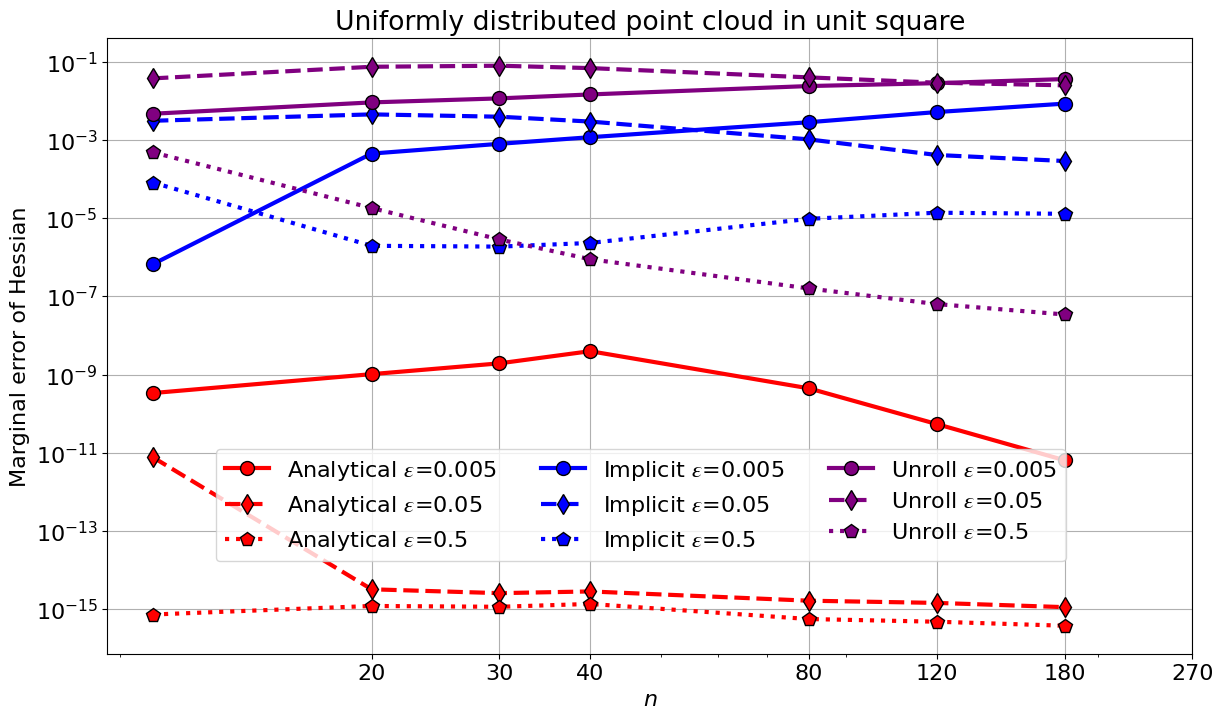

In [ ]:
list_legend = []
import matplotlib

font = {'size'   : 16}

matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize=(14, 8))


ax.plot(n_span, np.nanmean(error_a[:,0,:],axis=1),marker = "o", color="red",  markersize=10, linestyle="-",
        markeredgecolor="k",
        lw=3,label="Analytical $𝜀$=0.005" )

ax.plot(n_span, np.nanmean(error_a[:,1,:],axis=1),marker = "d", color="red",  markersize=10, linestyle="--",
        markeredgecolor="k",
        lw=3,label="Analytical $𝜀$=0.05" )
ax.plot(n_span, np.nanmean(error_a[:,2,:],axis=1),marker = "p", color="red",  markersize=10, linestyle=":",
        markeredgecolor="k",
        lw=3,label="Analytical $𝜀$=0.5" )

ax.plot(n_span, np.nanmean(error_i[:,0,:],axis=1),marker = "o", color="blue",  markersize=10, linestyle="-",
        markeredgecolor="k",
        lw=3,label="Implicit $𝜀$=0.005" )

ax.plot(n_span, np.nanmean(error_i[:,1,:],axis=1),marker = "d", color="blue",  markersize=10, linestyle="--",
        markeredgecolor="k",
        lw=3,label="Implicit $𝜀$=0.05" )
ax.plot(n_span, np.nanmean(error_i[:,2,:],axis=1),marker = "p", color="blue",  markersize=10, linestyle=":",
        markeredgecolor="k",
        lw=3,label="Implicit $𝜀$=0.5" )


ax.plot(n_span, np.nanmean(error_u[:,0,:],axis=1),marker = "o", color="purple",  markersize=10, linestyle="-",
        markeredgecolor="k",
        lw=3,label="Unroll $𝜀$=0.005" )

ax.plot(n_span, np.nanmean(error_u[:,1,:],axis=1),marker = "d", color="purple",  markersize=10, linestyle="--",
        markeredgecolor="k",
        lw=3,label="Unroll $𝜀$=0.05" )
ax.plot(n_span, np.nanmean(error_u[:,2,:],axis=1),marker = "p", color="purple",  markersize=10, linestyle=":",
        markeredgecolor="k",
        lw=3,label="Unroll $𝜀$=0.5" )

ax.set_yscale("log")
ax.set_xscale("log")
plt.xlabel("$n$")
plt.ylabel("Marginal error of Hessian")
ax.set_xticks([20,30, 40, 80, 120, 180, 270])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.grid()
ax.legend(loc=(0.1,0.15),ncol = len(ax.lines)/3 )
plt.title("Uniformly distributed point cloud in unit square")
plt.savefig("accuracy_uniform.pdf", format="pdf", bbox_inches="tight")
plt.show()